In [1]:
# https://discuss.pytorch.org/t/call-backward-on-function-inside-a-backpropagation-step/3793
# https://discuss.pytorch.org/t/implementing-a-custom-convolution-using-conv2d-input-and-conv2d-weight/18556
# https://discuss.pytorch.org/t/implementing-a-custom-convolution-using-conv2d-input-and-conv2d-weight/18556/21

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms

import numpy as np
import sys
sys.path.append('./')
from gated import Net, Net1, NetA, NetS, Conv2dFunction, Conv2dFunctionG, Conv2dFunctionG2

In [3]:
# device = torch.device("cpu")
device = torch.device("cuda")
dtype = torch.float
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 64

trainset = torchvision.datasets.CIFAR10(root='../data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=8)

testset = torchvision.datasets.CIFAR10(root='../data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=8)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# N, C_in, C_out, K_size = batch_size, 3, 12, 3
# Create random Tensors for weights.
conw1 = torch.randn(8,3,5,5, device=device, dtype=dtype, requires_grad=True)
conw2 = torch.randn(32,8,3,3, device=device, dtype=dtype, requires_grad=True)
conw3 = torch.randn(128,32,3,3, device=device, dtype=dtype, requires_grad=True)
conw4 = torch.randn(128,128,3,3, device=device, dtype=dtype, requires_grad=True)
conw5 = torch.randn(10,128,1,1, device=device, dtype=dtype, requires_grad=True)

# weight for normal
conw1 = torch.nn.init.xavier_uniform_(conw1, gain=1.0)
conw2 = torch.nn.init.xavier_uniform_(conw2, gain=1.0)
conw3 = torch.nn.init.xavier_uniform_(conw3, gain=1.0)
conw4 = torch.nn.init.xavier_uniform_(conw4, gain=1.0)
conw5 = torch.nn.init.xavier_uniform_(conw5, gain=1.0)

# weight for gated
# conw1g = conw1.clone().detatch(requires_grad=True)
conw1g = torch.tensor(conw1, device=device, dtype=dtype, requires_grad=True)
conw2g = torch.tensor(conw2, device=device, dtype=dtype, requires_grad=True)
conw3g = torch.tensor(conw3, device=device, dtype=dtype, requires_grad=True)
conw4g = torch.tensor(conw4, device=device, dtype=dtype, requires_grad=True)
conw5g = torch.tensor(conw5, device=device, dtype=dtype, requires_grad=True)

# weight for adam 
conw1a = torch.tensor(conw1, device=device, dtype=dtype, requires_grad=True)
conw2a = torch.tensor(conw2, device=device, dtype=dtype, requires_grad=True)
conw3a = torch.tensor(conw3, device=device, dtype=dtype, requires_grad=True)
conw4a = torch.tensor(conw4, device=device, dtype=dtype, requires_grad=True)
conw5a = torch.tensor(conw5, device=device, dtype=dtype, requires_grad=True)

conw1a_list = [conw1a, conw2a, conw3a, conw4a, conw5a]
conw1g_list = [conw1g, conw2g, conw3g, conw4g, conw5g]
# conw1_list = [conw1, conw2, conw3, conw4, conw5]
# print(conw1[0][0])
# print(torch.nn.init.xavier_uniform_(conw1, gain=1.0)[0][0])
# print(conw2)

/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/beomgon/anaconda3/envs/pytorch_retina/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: To copy

In [5]:
conw1 is conw1g

False

In [6]:
# Net1 act first
# Net bn first 
# Conv2dFunctionG 2*torch.sigmoid(out)
# Conv2dFunctionG2 2*(torch.sigmoid(torch.abs(out)))

# net = Net(conw1a_list, Conv2dFunctionG).to(device)
# netg = Net1(conw1g_list, Conv2dFunctionG).to(device)
neta = NetA().to(device)
criterion = nn.CrossEntropyLoss().to(device)

In [7]:
# parameter for adam should be same with other model
neta_dict = neta.state_dict()
for p in neta_dict :
    if 'conv1' in p :
        neta_dict[p] = conw1
    elif 'conv2' in p :
        neta_dict[p] = conw2
    elif 'conv3' in p :
        neta_dict[p] = conw3
    elif 'conv4' in p :
        neta_dict[p] = conw4
    elif 'conv5' in p :
        neta_dict[p] = conw5       
#     print(p)
#     print(neta.state_dict()[p].shape)
#     print()
neta.load_state_dict(neta_dict)

<All keys matched successfully>

In [8]:
image, labels = iter(trainloader).next()
optimizer = optim.Adam([conw1, conw2, conw3, conw4, conw5], lr=0.01)
optimizerbn = optim.Adam(neta.parameters(), lr=0.01)
outputs = neta(image.to(device)).to(device)
print(outputs.shape)
print(conw1[0][0][0])
# print(outputs.sum(dim=1))
# print(outputs)
loss = criterion(outputs, labels.to(device))
loss.backward()
# optimizer.step()
# optimizerbn.step()
print(conw1[0][0][0])
# print(torch.nn.Softmax(dim=1)(outputs).sum(dim=1))
# outputs
for i in neta.state_dict() :
    if 'bn1.wei' in i :
        print(neta.state_dict()[i][:5])


torch.Size([64, 10])
tensor([ 0.1130,  0.0017,  0.0098, -0.1232,  0.0967], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([ 0.1130,  0.0017,  0.0098, -0.1232,  0.0967], device='cuda:0',
       grad_fn=<SelectBackward>)
tensor([1., 1., 1., 1., 1.], device='cuda:0')


In [9]:
import math
import numpy as np

NUM_EPOCH = 15
# lr_list = [1] * NUM_EPOCH
# e = math.exp(1)
# for i,v in enumerate(lr_list) :
# #     lr_list[i] = 0.1 * (math.cos(i*math.pi/(NUM_EPOCH*2)))**4
#     lr_list[i] = 0.1 * math.exp(1.*i*-e/NUM_EPOCH)
# print(lr_list)
lr_list = [0.1, 0.1, 0.05, 0.05, 0.05, 0.02, 0.02, 
           0.01, 0.01, 0.01, 0.005, 0.002,
           0.001, 0.0005, 0.0005, 0.0005, 0.0001, 0.0001, 0.00005, 0.00005]


In [10]:
def test (model) :
    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            inputs, labels = data
            outputs = model(inputs.to(device))
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels.to(device)).sum().item()

    print('Accuracy of the network on the 10000 test images: %d %%' % (
        100 * correct / total))
    return (100 * correct / total)    

In [11]:
print('******************normal case with adam****************')
learning_rate = 0.001
criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(neta.parameters(), lr=learning_rate)
adam_loss = []
adam_accuracy = []
grad_mean = []
for epoch in range(NUM_EPOCH) :  
# for epoch in range(20) :   
    running_loss = 0.0
    grad = 0
    neta.train()
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        outputs = neta(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()  

        # print statistics
        running_loss += loss.item()
        grad += torch.norm(neta.conv1.weight.grad)
        if i % 400 == 399:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch +
                   1, i + 1, running_loss / (i+1)))
            print(torch.norm(neta.conv1.weight.grad))
            
        optimizer.step()
        optimizer.zero_grad()            
    
    neta.eval()
    test_acc = test(neta)
    adam_loss.append(running_loss/len(trainloader))
    grad_mean.append(grad/len(trainloader))
    adam_accuracy.append(test_acc)

******************normal case with adam****************
[1,   400] loss: 2.021
tensor(1.3172, device='cuda:0')
Accuracy of the network on the 10000 test images: 57 %
[2,   400] loss: 1.846
tensor(1.1839, device='cuda:0')
Accuracy of the network on the 10000 test images: 64 %
[3,   400] loss: 1.789
tensor(1.6049, device='cuda:0')
Accuracy of the network on the 10000 test images: 67 %
[4,   400] loss: 1.754
tensor(2.0947, device='cuda:0')
Accuracy of the network on the 10000 test images: 68 %
[5,   400] loss: 1.728
tensor(0.9243, device='cuda:0')
Accuracy of the network on the 10000 test images: 66 %
[6,   400] loss: 1.710
tensor(1.2966, device='cuda:0')
Accuracy of the network on the 10000 test images: 65 %
[7,   400] loss: 1.689
tensor(1.8355, device='cuda:0')
Accuracy of the network on the 10000 test images: 70 %
[8,   400] loss: 1.676
tensor(1.2665, device='cuda:0')
Accuracy of the network on the 10000 test images: 69 %
[9,   400] loss: 1.663
tensor(1.9148, device='cuda:0')
Accuracy 

In [12]:
# grad_mean

In [13]:
conw1a[0][0][0]

tensor([ 0.1130,  0.0017,  0.0098, -0.1232,  0.0967], device='cuda:0',
       grad_fn=<SelectBackward>)

In [14]:
# saved_p = neta.state_dict()
# for p in saved_p :
#     if 'conv1.weight' in p :
#         conw1a = conw1g = saved_p[p]
#     elif 'conv2.weight' in p :
#         conw2a = conw2g = saved_p[p]
#     elif 'conv3.weight' in p :
#         conw3a = conw3g = saved_p[p]     
#     elif 'conv4.weight' in p :
#         conw4a = conw4g = saved_p[p]  
#     elif 'conv5.weight' in p :
#         conw5a = conw5g = saved_p[p]        
        
conw1a_list = [conw1a, conw2a, conw3a, conw4a, conw5a]
conw1g_list = [conw1g, conw2g, conw3g, conw4g, conw5g]

net = Net(conw1a_list, Conv2dFunctionG).to(device)
netg = Net(conw1g_list, Conv2dFunction).to(device)
# print(conw1a[0][0][0])
# # print(conw1a_list[0][0][0][0])

In [15]:
print('******************normal case****************')
# lr_list = [0.05] * NUM_EPOCH
criterion = nn.CrossEntropyLoss().to(device)

gated2_loss = []
gated2_accuracy = []
# optimizer = optim.SGD(conw1a_list, lr=learning_rate, momentum=0.9)
# optimizerbn = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9) 
for epoch in range(NUM_EPOCH) :   
    running_loss = 0.0
    learning_rate = lr_list[epoch]
    optimizer = optim.SGD(conw1a_list, lr=learning_rate)
    optimizerbn = optim.SGD(net.parameters(), lr=learning_rate)       
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data
        

        outputs = net(inputs.to(device))
        loss = criterion(outputs, labels.to(device))

        loss.backward()   

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (i+1)))   
            print(torch.norm(conw1a.grad))
            
        optimizer.step()
        optimizerbn.step()            
            
        optimizer.zero_grad()
        optimizerbn.zero_grad()            
            
    test_acc = test(net)
    gated2_loss.append(running_loss/len(trainloader))
    gated2_accuracy.append(test_acc)    

******************normal case****************
[1,   400] loss: 2.046
tensor(0.8240, device='cuda:0')
Accuracy of the network on the 10000 test images: 53 %
[2,   400] loss: 1.880
tensor(0.9336, device='cuda:0')
Accuracy of the network on the 10000 test images: 60 %
[3,   400] loss: 1.785
tensor(0.6387, device='cuda:0')
Accuracy of the network on the 10000 test images: 68 %
[4,   400] loss: 1.746
tensor(0.5217, device='cuda:0')
Accuracy of the network on the 10000 test images: 66 %
[5,   400] loss: 1.716
tensor(0.5745, device='cuda:0')
Accuracy of the network on the 10000 test images: 69 %
[6,   400] loss: 1.679
tensor(0.4693, device='cuda:0')
Accuracy of the network on the 10000 test images: 71 %
[7,   400] loss: 1.655
tensor(0.6778, device='cuda:0')
Accuracy of the network on the 10000 test images: 72 %
[8,   400] loss: 1.638
tensor(0.4589, device='cuda:0')
Accuracy of the network on the 10000 test images: 71 %
[9,   400] loss: 1.630
tensor(1.0728, device='cuda:0')
Accuracy of the net

In [16]:
# print(net.conv11.weight.grad) 
# print(net.conv21.bias.grad)
# net.bn1.weight.grad
image, labels = iter(trainloader).next()
optimizer = optim.Adam(conw1a_list, lr=0.01)
optimizerbn = optim.Adam(net.parameters(), lr=0.01)
outputs = net(image.to(device)).to(device)
print(outputs.shape)
print(conw1[0][0][0])
# print(outputs.sum(dim=1))
# print(outputs)
loss = criterion(outputs, labels.to(device))
loss.backward()

torch.Size([64, 10])
tensor([ 0.1130,  0.0017,  0.0098, -0.1232,  0.0967], device='cuda:0',
       grad_fn=<SelectBackward>)


In [17]:
# temp = torch.randn(4,3,2,2)
# temp[0]
# # print(temp[0])
# temp1 = temp.view(4,-1)
# # print(temp[0])
# so = torch.sigmoid(temp1)
# torch.norm(temp1, dim=1)
# # denom = torch.norm(temp1, dim=1).unsqueeze(dim=1)
# # denom.view(4,-1)
# # (temp1 / torch.sqrt(denom)).view(4,3,2,2)[0]

In [18]:
c1, c2, c3, c4, c5 = net.conv_return()
c2.shape

torch.Size([64, 32, 16, 16])

In [19]:
# c2

In [20]:
# conw1a_list[1].grad

In [21]:
v = (torch.norm(c2.view(64, -1), dim=1)).unsqueeze(dim=1)

d = c2.view(64, -1) / v
torch.norm(d, dim=1)

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000], device='cuda:0', grad_fn=<CopyBackwards>)

In [22]:
# c5_1 = c5.view(64,-1) / torch.sqrt(torch.norm(c5.view(64,-1), dim=1)).unsqueeze(dim=1)
# torch.abs(c5_1.view(64, 10, 2, 2))[0]

In [23]:
# c2_1 = c2.view(64,-1) / torch.sqrt(torch.norm(c2.view(64,-1), dim=1)).unsqueeze(dim=1)
# torch.abs(c2_1.view(64, 32, 16, 16))[0]

In [24]:
(conw1a_list[4].shape)

torch.Size([10, 128, 1, 1])

In [25]:

print('******************grad gated****************')
# lr_list = [0.05] * NUM_EPOCH
criterion = nn.CrossEntropyLoss().to(device)

gated1_loss = []
gated1_accuracy = []
learning_rate = 0.1
# optimizer = optim.SGD(conw1g_list, lr=learning_rate, momentum=0.9)
# optimizerbn = optim.SGD(netg.parameters(), lr=learning_rate, momentum=0.9)  
for epoch in range(NUM_EPOCH) :    
    running_loss = 0.0
    learning_rate = lr_list[epoch]
#     learning_rate = 0.05
    optimizer = optim.SGD(conw1g_list, lr=learning_rate)
    optimizerbn = optim.SGD(netg.parameters(), lr=learning_rate)    
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        outputs = netg(inputs.to(device))
        loss = criterion(outputs, labels.to(device))
        loss.backward()

        # print statistics
        running_loss += loss.item()
        if i % 400 == 399:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / (i+1)))
            print(torch.norm(conw1g.grad))
            
        optimizer.step()
        optimizerbn.step()
        
        optimizer.zero_grad()
        optimizerbn.zero_grad()            
            
    test_acc = test(netg)
    gated1_loss.append(running_loss/len(trainloader))
    gated1_accuracy.append(test_acc)

******************grad gated****************
[1,   400] loss: 2.059
tensor(0.6066, device='cuda:0')
Accuracy of the network on the 10000 test images: 53 %
[2,   400] loss: 1.887
tensor(0.3863, device='cuda:0')
Accuracy of the network on the 10000 test images: 61 %
[3,   400] loss: 1.799
tensor(0.4862, device='cuda:0')
Accuracy of the network on the 10000 test images: 64 %
[4,   400] loss: 1.762
tensor(0.5870, device='cuda:0')
Accuracy of the network on the 10000 test images: 67 %
[5,   400] loss: 1.734
tensor(1.0514, device='cuda:0')
Accuracy of the network on the 10000 test images: 68 %
[6,   400] loss: 1.696
tensor(0.5906, device='cuda:0')
Accuracy of the network on the 10000 test images: 69 %
[7,   400] loss: 1.681
tensor(0.5493, device='cuda:0')
Accuracy of the network on the 10000 test images: 70 %
[8,   400] loss: 1.664
tensor(0.4752, device='cuda:0')
Accuracy of the network on the 10000 test images: 70 %
[9,   400] loss: 1.654
tensor(0.8805, device='cuda:0')
Accuracy of the netw

In [26]:
for k in net.state_dict() :
    if 'bn1' in k :
        print(k)
        print(net.state_dict()[k])      

bn1.weight
tensor([1.2686, 0.8932, 0.8955, 1.0403, 1.1475, 0.8215, 1.0426, 0.8289],
       device='cuda:0')
bn1.bias
tensor([ 0.1005,  0.1046,  0.0775, -0.0125, -0.0153,  0.0469, -0.0091, -0.0649],
       device='cuda:0')
bn1.running_mean
tensor([0.2115, 0.2026, 0.1683, 0.1823, 0.2687, 0.1982, 0.1819, 0.3053],
       device='cuda:0')
bn1.running_var
tensor([0.1940, 0.1449, 0.0929, 0.0871, 0.1685, 0.1048, 0.0925, 0.2041],
       device='cuda:0')
bn1.num_batches_tracked
tensor(14086, device='cuda:0')


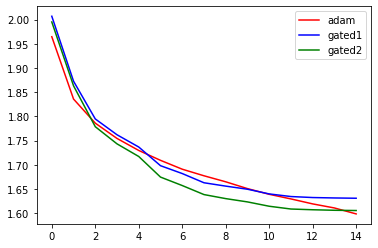

In [27]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.arange(0,NUM_EPOCH,1)
plt.plot(X, adam_loss,  color='red')
plt.plot(X, gated1_loss, color='blue')
plt.plot(X, gated2_loss, color='green')
# plt.plot(X, gated3_loss, color='yellow')
# plt.plot(X, gated4_loss, color='orange')
plt.legend(['adam', 'gated1', 'gated2', 'gated3', 'gated4'])
plt.show()


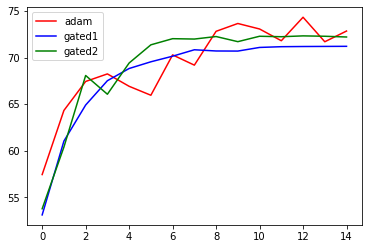

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

X = np.arange(0,NUM_EPOCH,1)
plt.plot(X, adam_accuracy,  color='red')
plt.plot(X, gated1_accuracy, color='blue')
plt.plot(X, gated2_accuracy, color='green')
# plt.plot(X, gated3_accuracy, color='yellow')
# plt.plot(X, gated4_accuracy, color='orange')
plt.legend(['adam', 'gated1', 'gated2', 'gated3', 'gated4'])
plt.show()